In [1]:
import math
import matplotlib as mpl
# mpl.use('pgf')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import rc

%matplotlib inline

print plt.style.available
# plt.style.use('classic')

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [2]:
## Change default plot style
def_style = 'ggplot'
plt.style.use(def_style)
# plt.style.use('grayscale')
fig_scl = 3
def_clr = cm.inferno

def figsize(scale, height_ratio=(np.sqrt(5.0)-1.0)/2.0):
    # got after running \the\textwidth
    fig_width_pt = 345.000
    
    inches_per_pt = 1.0/72.0
    
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*height_ratio
    fig_size = (fig_width,fig_height)
    
    return fig_size

def setup_tex():
    """
    formats the plots for production with latex
    """
    pgf_with_latex = {
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["palatino"],
        "font.sans-serif": [],
        "font.monospace": [],
        "axes.labelsize": 12,
        "text.fontsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.figsize": figsize(1)
    }
    mpl.rcParams.update(pgf_with_latex)

def savefig(filename):
#     pass
#     plt.savefig('{}.pgf'.format(filename))
    plt.savefig('{}.pdf'.format(filename))
    plt.savefig('{}.eps'.format(filename))

In [3]:
## Load all required data
print "Loading data into pandas data frame..."
data_spring_coeff = pd.read_csv("p1_coeff.csv")
data_damped_motion = {k:pd.read_csv("DM" + str(k) + ".csv")
                          for k in [2, 3, 4, 5]}
masses = {2:0.29943, 3: 0.39908, 4:0.49909, 5:0.59926}
print "Done loading."

Loading data into pandas data frame...
Done loading.


In [4]:
def get_intercept(m, (x, y)):
    """
    returns the y-intercept of a line given a
    single point <(x, y)> and the corresponding
    slope <m>
    """
    return (y - m*x)

def get_slope((x1, y1), (x2, y2)):
    """
    returns the slope of the line connecting the
    points <(x1, y1)> and <(x2, y2)>.
    """
    return float(y2 - y1)/float(x2 - x1)

def get_latex_table(data_table, header):
    """
    Formats and prints out an n by m data set as a latex table
    """
    print '\\begin{tabular}{' + 'l'*len(header) + '}\\\\'
    for cl, t in zip(header, range(len(header))):
        if t != len(header) - 1:
            print cl + '\t& ',
        else:
            print cl + '\\\\\n'
    for p in data_table:
        print '\t&'.join(str(k) for k in p) + '\\'
    print '\\end{tabular}'
# '&'.join(str(k) for k in range(10))

# Part I: Calculation of spring constant

We use the force ($F$) and position ($x$) data collected in the first part of the experiment to get the line of best fit for the $x$-$F$ graph.

The slope of this line $\left(m = \displaystyle\frac{\Delta F}{\Delta x}\right)$ will give us $-k$ (since the position sensor was located at the bottom and therefore records $-x$ instead of $x$).

Hence,

$-k = \displaystyle\frac{\Delta F}{\Delta x}$

In [5]:
# store the Position (X) and Force (F) data in arrays
X_rw = np.array([data_spring_coeff['P M' + str(k)]
                     for k in range(6)])
F_rw = np.array([data_spring_coeff['F M' + str(k)]
                     for k in range(6)])

# calculate the mean value and related uncertainties
# (standard deviation)
X = [(x.mean(), x.std()) for x in X_rw]
F = [(f.mean(), f.std()) for f in F_rw]

print X

[(0.31733200000000006, 0.00073059975362711489), (0.29065999999999997, 0.0011799999999999983), (0.26306000000000002, 0.0017596590578859317), (0.23413199999999995, 0.00033849076796864082), (0.20786000000000002, 0.0013741906709041499), (0.18293199999999998, 0.0025122452109617032)]


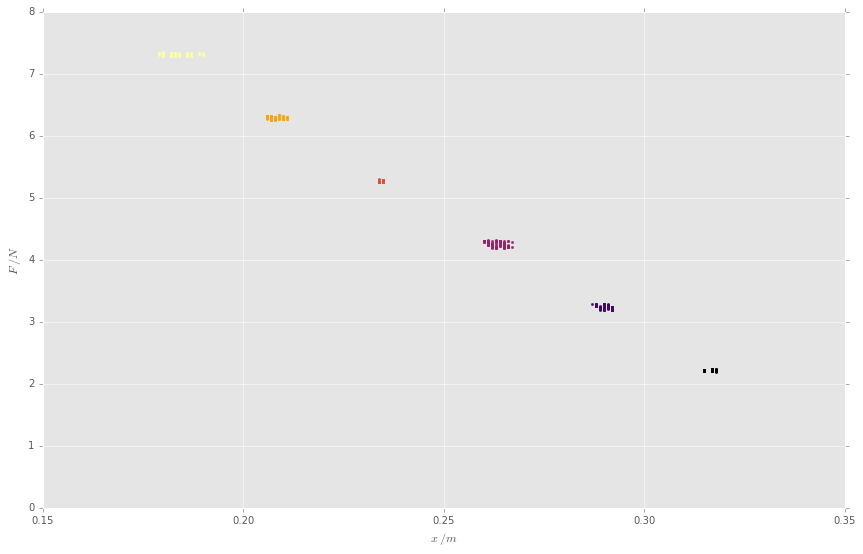

In [6]:
## Plot the raw data points
plt.clf()
plt.figure(figsize=figsize(fig_scl))

plt.xlim([0.15, 0.35])
plt.ylim([0.0, 8.00])

plt.xlabel('$x\; /m$')
plt.ylabel('$F\; /N$')

c = def_clr(np.linspace(0, 1, len(X_rw)))

for (x_p, f_p, c) in zip(X_rw, F_rw, c):
    plt.scatter(x_p, f_p, marker='.', color=c)
savefig('pt1_x-F_raw_graph')

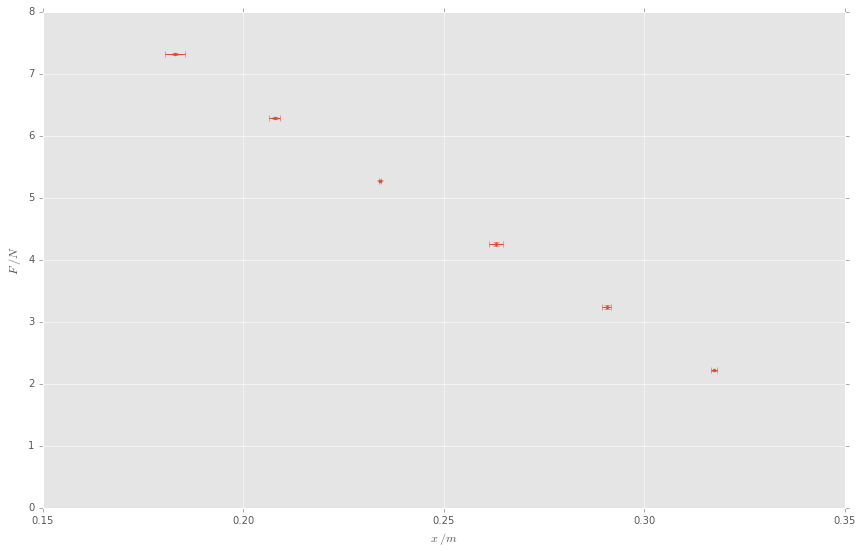

In [7]:
# Plot the x-F graph with error bars.
# Also, save the file with a proper name.
plt.clf()
plt.figure(figsize=figsize(fig_scl))

plt.xlim([0.15, 0.35])
plt.ylim([0.0, 8.00])

plt.xlabel('$x\; /m$')
plt.ylabel('$F\; /N$')

plt.errorbar([x[0] for x in X],
             [f[0] for f in F],
                 xerr=[x[1] for x in X],
                 yerr=[f[1] for f in F],
             fmt='--.', linestyle="None")

savefig('pt1_x-F_graph')

In [8]:
## Get the line of best fit for the x-F graph
m, b = np.polyfit(X_rw.flatten(), F_rw.flatten(), 1)

## Get the other bounding lines for the main line
m_1 = get_slope((X[0][0]-X[0][1],
                 F[0][0]-F[0][1]),
                (X[-1][0]+X[-1][1],
                 F[-1][0]+F[-1][1]))

b_1 = get_intercept(m_1, (X[0][0]-X[0][1],
                          F[0][0]-F[0][1]))

m_2 = get_slope((X[0][0]+X[0][1],
                 F[0][0]+F[0][1]),
                (X[-1][0]-X[-1][1],
                 F[-1][0]-F[-1][1]))

b_2 = get_intercept(m_2, (X[0][0]+X[0][1],
                          F[0][0]+F[0][1]))

## Print out the values
print "Line of best fit:"
print "y = {}x + {}".format(m, b)
print ""
print "Lines of min/max slope:"
print "* y = {}x + {}".format(m_1, b_1)
print "* y = {}x + {}".format(m_2, b_2)

Line of best fit:
y = -37.5365286233x + 14.1271896573

Lines of min/max slope:
* y = -39.0690034548x + 14.5782117522
* y = -36.8643692166x + 13.9526105591


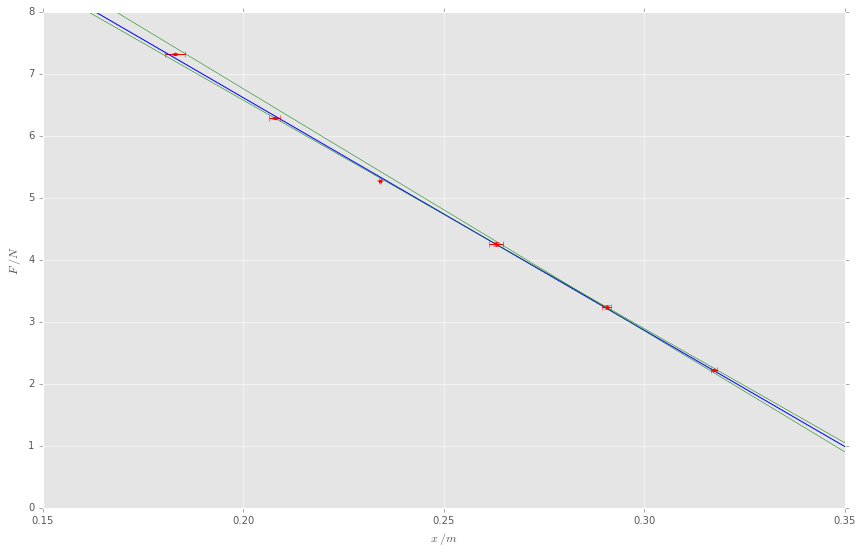

In [9]:
# Plot the lines of best and worst fit.
plt.clf()
plt.figure(figsize=figsize(fig_scl))

plt.xlim([0.15, 0.35])
plt.ylim([0.0, 8.00])

plt.xlabel('$x\; /m$')
plt.ylabel('$F\; /N$')

xs = np.linspace(0.15, 0.35, 10)

plt.plot(xs, m*xs+b, 'b-', linewidth=1)
plt.plot(xs, m_1*xs+b_1, 'g-', linewidth=0.5)
plt.plot(xs, m_2*xs+b_2, 'g-', linewidth=0.5)

plt.errorbar([x[0] for x in X],
             [f[0] for f in F],
             xerr=[x[1] for x in X],
             yerr=[f[1] for f in F],
             fmt='r.',
             linestyle="None",
             ecolor='r')

savefig('pt1_x-F_graph_fit_lines')

In [10]:
## Calculation of coefficient of friction and the related
## uncertainties
k = -m
k_1 = -m_1
k_2 = -m_2

k_err = (k_1 - k_2)/2.0

spring_coeff = k
spring_coeff_err = k_err

print "Spring coeff."
print "Best:\t{} N/m".format(round(k, 3))
print "Max:\t{} N/m".format(round(k_1, 3))
print "Min:\t{} N/m".format(round(k_2, 3))
print "A. Err:\t{} N/m".format(round(k_err, 2))
print "P. Err:\t{}%".format(round((k_err/k)*100, 2))

Spring coeff.
Best:	37.537 N/m
Max:	39.069 N/m
Min:	36.864 N/m
A. Err:	1.1 N/m
P. Err:	2.94%


# Part 2: Calculation of Damping coeff.

In a damped simple harmonic motion, the location $x$ of the particle is given by:

$\large  x(t) = Ae^{\frac{-bt}{2m}}\cos{(\omega^\prime t + \phi)}$

Where
* $A$ is the initial alplitude
* $m$ is the mass of the body
* $b$ is the damping coeff.
* $\displaystyle\omega^\prime = \sqrt{\omega^2 - \gamma^2} = \sqrt{\frac{k}{m} - \frac{b^2}{4m^2}}$

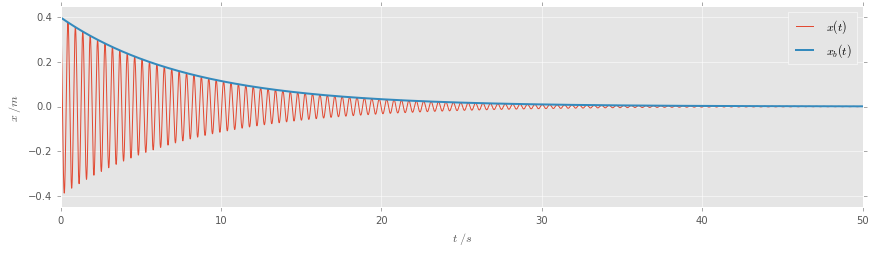

In [11]:
## Damped simple harmonic motion: EXAMPLE
def ex_damped_shm(A, m, b, k, ph = 0):
    t = np.linspace(0, 50, 10000)
    gamma = float(b)/float(2*m)
    omega_prime = math.sqrt(float(k)/float(m))
#     omega_prime = math.sqrt(omega**2 - gamma**2)
    x = []
    for T in t:
        trig_coeff = (math.cos(omega_prime*T + ph))
        exp = ((-1*T*float(b))/float(2*m))
        x.append(A*(math.e**exp)*trig_coeff)
        
    x_e = A*(math.e**((-1*t*float(b))/float(2*m)))
    
    plt.plot(t, x, label="$x(t)$")
    plt.plot(t, x_e, label="$x_b(t)$", linewidth=2)
    plt.legend()

plt.clf()
plt.figure(figsize=figsize(fig_scl, height_ratio=(1.0/4.0)))
plt.xlim([0, 50])
plt.xlabel('$t\;/s$')
plt.ylim([-0.45, 0.45])
# plt.yscale('log')
plt.ylabel('$x\;/m$')
ex_damped_shm(0.4, 0.2, 0.05, 37)

savefig("ex_damped")

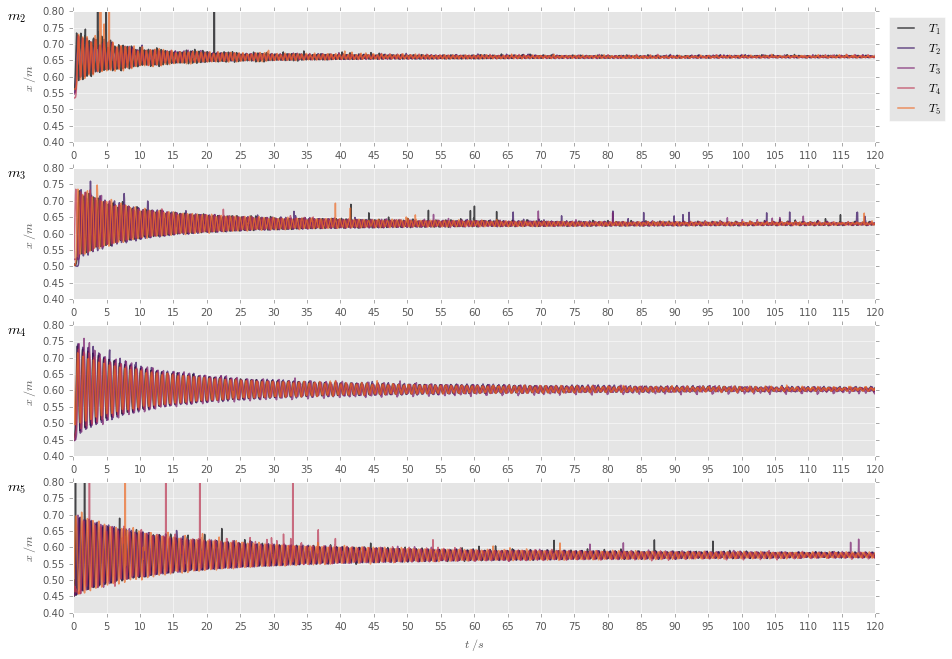

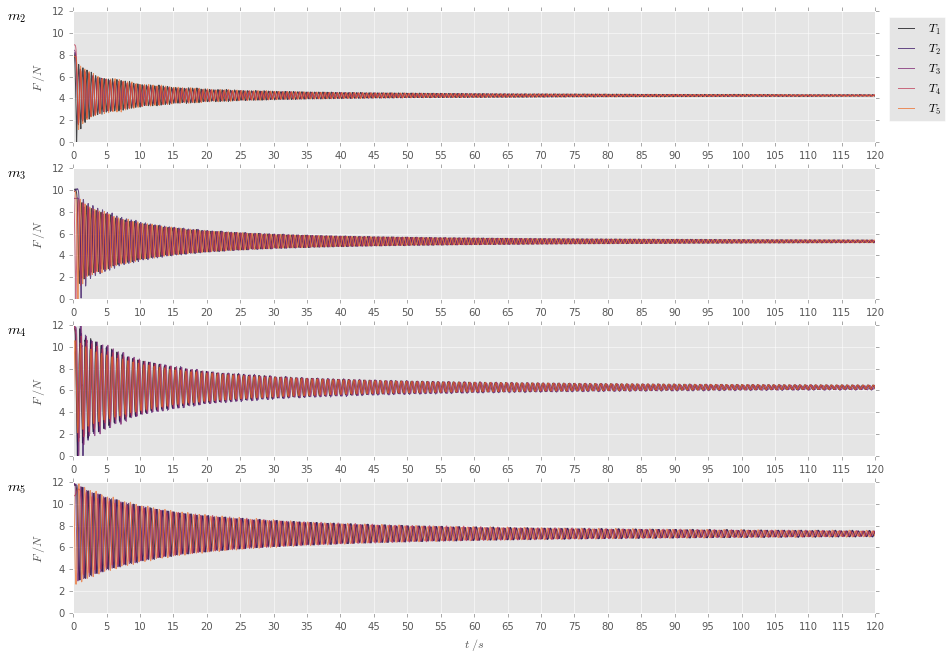

In [12]:
def plot_data_sets(data_set):
    """
    plots the data set with all the trials to be used in the lab.
    """
#     gs1 = gridspec.GridSpec(4, 2)
#     gs1.update(wspace=0.1, hspace=0.1) set the spacing between axes. 
    colors = def_clr(np.linspace(0, 1, 7))
    plt.figure(figsize = figsize(3, 0.15*5))
    for i in range(4):
        plt.subplot(4, 1, i+1)
        plt.xlim(0, 120)
        plt.ylim(0.4, 0.8)
        plt.xticks(np.linspace(0, 120, 25))
        plt.ylabel('$x\;/m$')
        ts = data_set[i+2]['T']
        for tn, c in zip(range(1, 6), colors):
            ps = data_set[i+2]['M'+str(i + 2)+" P"+str(tn)]
            plt.plot(ts, ps, color=c, linewidth=1.5, alpha=0.7, label='$T_'+str(tn)+'$')
            plt.title('$m_'+str(i + 2)+'$', y=0.9, x=-0.07)
            if i==0:
                plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
            elif i == 3:
                plt.xlabel('$t\;/s$')
    savefig('data_raw_x')
    
    plt.figure(figsize = figsize(3, 0.15*5))
    for i in range(4):
        plt.subplot(4, 1, i+1)
        plt.xlim(0, 120)
        plt.ylim(0, 12)
        plt.xticks(np.linspace(0, 120, 25))
        plt.ylabel('$F\;/N$')
        ts = data_set[i+2]['T']
        for tn, c in zip(range(1, 6), colors):
            ps = data_set[i+2]['M'+str(i + 2)+" F"+str(tn)]
            plt.plot(ts, ps, color=c, linewidth=1, alpha=0.7, label='$T_'+str(tn)+'$')
            plt.title('$m_'+str(i + 2)+'$', y=0.9, x=-0.07)
            if i==0:
                plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
            elif i == 3:
                plt.xlabel('$t\;/s$')
    savefig('data_raw_F')
    
plot_data_sets(data_damped_motion)

## Change of Phase

Since all data points have different values for the phase angle, $\phi$, for the sake of convinience, we will bring all the phases to $0$ which will then allow us to take averages, etc.

Since the $F$ value has the most consistent readings (least number of outliers), we shall use that to find the phase angle and then bring it to $0$.

In [13]:
def get_data_subset(data_set, colmn):
    """
    returns a subset of the data set as a dictionary of
    (m, c):{<dat>} values for the selected column <colmn>.
    """
    return {(mn, cn):(data_set[mn][['T', 'M' + str(mn) + ' ' + colmn + str(cn)]]).
                         rename(columns={'M' + str(mn) + ' ' + colmn + str(cn):colmn})
                         for (mn, cn) in [(mn, cn)
                            for mn in range(2, 6)
                            for cn in range(1, 6)]}

def get_phase_shifts(source_set):
    """
    Given a data set <source_set>, identiy the first through
    and return a dictionary of (m, tn):T values. Where
        m    is the mass
        tn   is the trial number
        T    is the timestamp
    """
    return {(m, i):source_set[m, i]
                  [source_set[m, i].F == oscDT_F[m, i]["F"].min()]
                  ["T"].values[0]
                  for (m, i) in [(m, i)
                            for m in range(2, 6)
                            for i in range(1, 6)]}

oscDT_F = get_data_subset(data_damped_motion, 'F')
oscDT_V = get_data_subset(data_damped_motion, 'V')
oscDT_P = get_data_subset(data_damped_motion, 'P')
oscDT_A = get_data_subset(data_damped_motion, 'A')

# get_phase_shifts(oscDT_F)

In [14]:
# ## view one data set (to check the phase thing)
# def plot_trials():
#     dt_set = oscDT_P
#     plt.clf()
#     plt.figure(figsize=figsize(fig_scl, height_ratio=6*(1.0/4.0)))
#     for fn in range(1, 6):
#         plt.subplot(5, 1, fn)
#     #     plt.xlim([0, dt_set[(3, 1)]["T"].max()])
#         plt.xlim([0, 20])
#     #     plt.ylim([0, 9])
#         plt.yscale('log')
#         plt.plot(dt_set[(2, fn)]["T"], dt_set[(2, fn)]['P'], label="$T_"+str(fn)+"$")
#         plt.legend()
#     plt.xlabel('$x$')
    
# plot_trials()

In [15]:
## Bring everything to the same phase.

## Get the phase change dictionary
phase_shifts = get_phase_shifts(oscDT_F)
# print phase_shifts

## create new dict for shifted values
shifted_data = {(mn, tn):data_damped_motion[mn]
                [["T"] +
                 ["M"+str(mn)+" "+C+str(tn)
                          for C in ['F', 'P', 'V', 'A']]]
                    for (mn, tn) in [(mn, tn)
                            for mn in range(2, 6)
                            for tn in range(1, 6)]}

## Shift phase
shifted_data = {(mn, tn):shifted_data[(mn, tn)][shifted_data[(mn, tn)]
                                                ['T'] >= phase_shifts[(mn, tn)]]
                    for (mn, tn) in [(mn, tn)
                            for mn in range(2, 6)
                            for tn in range(1, 6)]}

## Eliminate excess data
shifted_data = {(mn, tn):shifted_data[(mn, tn)][shifted_data[(mn, tn)]
                                                ['T'] <= phase_shifts[(mn, tn)]+100]
                    for (mn, tn) in [(mn, tn)
                            for mn in range(2, 6)
                            for tn in range(1, 6)]}

## Start time at zero, reset indices, rename columns
for k in shifted_data.keys():
    shifted_data[k]['T'] = shifted_data[k]['T'] - phase_shifts[k]
    shifted_data[k].index = range(len(shifted_data[k]))
    shifted_data[k] = shifted_data[k].rename(columns={
                                                ('M' + str(k[0]) + " F" + str(k[1])):'F',
                                                ('M' + str(k[0]) + " P" + str(k[1])):'P',
                                                ('M' + str(k[0]) + " V" + str(k[1])):'V',
                                                ('M' + str(k[0]) + " A" + str(k[1])):'A'
                                                    })

## Eliminate excess data (everything after 100s)
print shifted_data[(3, 1)].head(3)
print shifted_data[(3, 1)].tail(3)

print 'M\t T1 \t T2 \t T3 \t T4 \t T5'
for m in masses.keys():
    print '$m_' + str(m) + '$\t& {}\t& {}\t& {}\t& {}\t& {}\\\\'.format(phase_shifts[(m, 1)], phase_shifts[(m, 2)],
                                         phase_shifts[(m, 3)], phase_shifts[(m, 4)],
                                         phase_shifts[(m, 5)])
phase_shifts

      T        F        P        V        A
0  0.00  1.42760  0.73073 -0.12215 -7.10388
1  0.04  2.13798  0.72359 -0.46229 -6.49953
2  0.08  2.97815  0.69066 -0.71820 -4.01609

[3 rows x 5 columns]
           T        F        P        V        A
2498   99.92  5.41668  0.62481 -0.03735  0.31746
2499   99.96  5.43034  0.62399 -0.00953  0.47771
2500  100.00  5.42351  0.62453  0.00991  0.41128

[3 rows x 5 columns]
M	 T1 	 T2 	 T3 	 T4 	 T5
$m_2$	& 0.52	& 0.8	& 0.8	& 0.84	& 0.8\\
$m_3$	& 0.96	& 1.2	& 1.32	& 0.4	& 0.72\\
$m_4$	& 0.64	& 0.68	& 0.84	& 0.84	& 0.68\\
$m_5$	& 0.92	& 1.04	& 0.72	& 1.56	& 0.44\\


{(2, 1): 0.52000000000000002,
 (2, 2): 0.80000000000000004,
 (2, 3): 0.80000000000000004,
 (2, 4): 0.83999999999999997,
 (2, 5): 0.80000000000000004,
 (3, 1): 0.95999999999999996,
 (3, 2): 1.2,
 (3, 3): 1.3200000000000001,
 (3, 4): 0.40000000000000002,
 (3, 5): 0.71999999999999997,
 (4, 1): 0.64000000000000001,
 (4, 2): 0.68000000000000005,
 (4, 3): 0.83999999999999997,
 (4, 4): 0.83999999999999997,
 (4, 5): 0.68000000000000005,
 (5, 1): 0.92000000000000004,
 (5, 2): 1.04,
 (5, 3): 0.71999999999999997,
 (5, 4): 1.5600000000000001,
 (5, 5): 0.44}

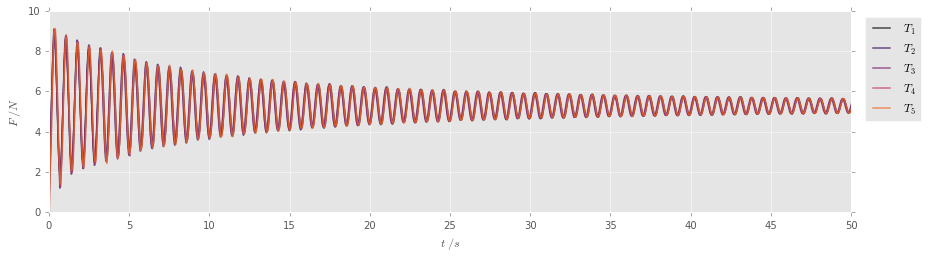

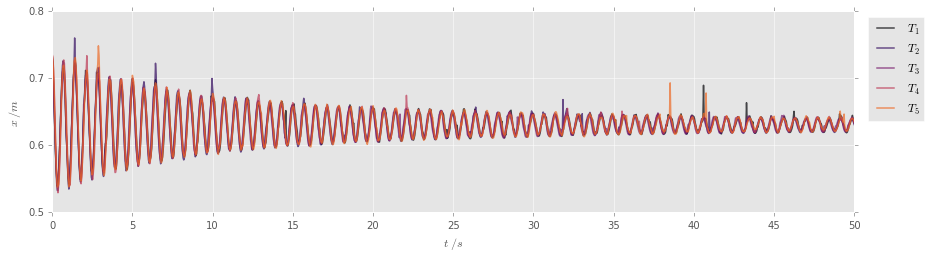

In [16]:
def plot_shifted():
    ## to view parts of the data set
    dt_set = shifted_data
    plt.clf()
    colors = def_clr(np.linspace(0, 1, 7))
    plt.figure(figsize=figsize(fig_scl, height_ratio=(1.0/4.0)))
    for tn, c in zip(range(1, 6), colors):
    #     plt.subplot(5, 1, tn)
    #     plt.xlim([0, dt_set[(2, tn)]["T"].max()])
        plt.xlim([0, 50])
        plt.xticks(np.linspace(0, 50, 11))
        plt.ylim([0, 10])
#         plt.ylim([0.0, 0.75])
#         plt.yscale('log')
        plt.plot(dt_set[(3, tn)]['T'],
                 dt_set[(3, tn)]['F'],
                 label="$T_"+str(tn)+"$",
                 color=c,
                 linewidth=1.5,
                 alpha=0.7)
        plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.xlabel('$t\;/s$')
    plt.ylabel('$F\;/N$')
    savefig('m3F_shifted')
    
    plt.figure(figsize=figsize(fig_scl, height_ratio=(1.0/4.0)))
    for tn, c in zip(range(1, 6), colors):
    #     plt.subplot(5, 1, tn)
    #     plt.xlim([0, dt_set[(2, tn)]["T"].max()])
        plt.xlim([0, 50])
        plt.xticks(np.linspace(0, 50, 11))
#         plt.ylim([0, 10])
#         plt.ylim([0.0, 0.75])
#         plt.yscale('log')
        plt.plot(dt_set[(3, tn)]['T'],
                 dt_set[(3, tn)]['P'],
                 label="$T_"+str(tn)+"$",
                 color=c,
                 linewidth=1.5,
                 alpha=0.7)
        plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.xlabel('$t\;/s$')
    plt.ylabel('$x\;/m$')
    plt.yticks([0.5, 0.6, 0.7, 0.8])
    savefig('m3x_shifted')
    
    
plot_shifted()

## Average and Data Centering

Now that we have brought everything to the same phase, we can take the average $\bar{x}$ of the data set.

$$\bar{x} = \frac{\displaystyle\sum_{i = 0}^N x(T_i)}{N}$$ (here $T_i$ is the value at trial $i$ and $N$ is the number of trials.

To center the data, we convert all our $x$s to 

$x = x - \bar{x}$

This brings the mean to zero and would make comparison with other data sets easier.

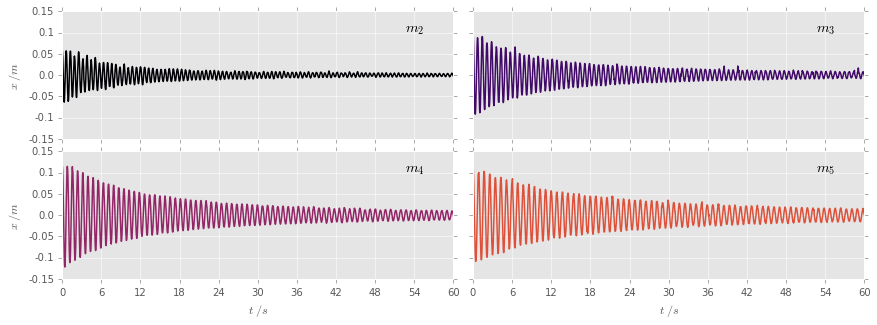

In [17]:
def center_data(dt_set):
    """
    centers the data i.e., for each data point d_i we replace it with
    d_i = d_i - avg(d)
    
    returns: the centered data set.
    """
    for col in [k for k in list(dt_set) if k != 'T']:
        dt_set[col] = dt_set[col] - dt_set[col].mean()
    return dt_set

def get_average(dt_set, m):
    """
    returns a data frame with the average values
    from different trials.
    
    returns:
        - pandas.dataframe with average values.
    """
    averages = pd.DataFrame(index=(range(len(shifted_data[2, 1]))))
    averages['T'] = dt_set[m, 1]['T']
    for col in list(['P', 'F']):
        init_avg = sum([dt_set[m, k][col][0] for k in range(1, 6)])/5.0
        temp_frame = pd.DataFrame(index=range(len(dt_set[m, 1])),
                                  columns=[])
        for tn in range(1, 6):
            temp_frame[col + str(tn)] = dt_set[m, tn][col]
        if col == 'P':
            temp_frame = temp_frame[temp_frame <= init_avg]
        elif col == 'F':
            temp_frame = temp_frame[temp_frame >= init_avg]
        averages[col] = temp_frame.T.mean()
    return center_data(averages)


average_shifted_data_full = {m:get_average(shifted_data, m) for m in range(2, 6)}
plt.figure(figsize=figsize(3, 2.0/6.0))
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
colors = def_clr(np.linspace(0, 1, 6))
for m, c in zip(masses.keys(), colors):
    plt.subplot(2, 2, m - 1)
    # plt.yscale('log', basey=np.e)
    # plt.ylim([e**-7, e**-3])
    plt.xlim([0, 60])
#     plt.
    plt.xticks(np.linspace(0, 60, 11), [])
    plt.yticks(np.linspace(-0.15, 0.15, 7), [])
    plt.ylim([-0.15, 0.15])
    plt.plot(average_shifted_data_full[m]['T'], average_shifted_data_full[m]['P'],
             linewidth=1.5, label = '$m_'+str(m)+'$', color=c)
    plt.title('$m_'+str(m)+'$', loc='center', y=0.8, x=0.9)
    if m in [2, 4]:
        plt.yticks(np.linspace(-0.15, 0.15, 7), np.linspace(-0.15, 0.15, 7))
        plt.ylabel('$x\;/m$')
    if m in [4, 5]:
        plt.xticks(np.linspace(0, 60, 11), range(0, 61, 6))
        plt.xlabel('$t\;/s$')
savefig('centered_m')

## Peak finding.

The averaged and centered data can now be used to find the points where the function peaks.

This will finally help us find the best fit for the enveloping bounding curve $x_b(t)$ for the position.

In [18]:
def get_peaks(data_set):
    """
    Given a data set with average values,
        {m:<set>}
    we get the time where the value of the
    force dips.
    
    returns:
        {m:<peak time list>}
    """
    peaks = {}
    for m in data_set.keys():
        f = data_set[m].values[1:-1, 2]
        ts = []
        for i in data_set[m].index[0:-2]:
            if i < 2:
                if i == 0:
                    if f[i] <= f[i+1]:
                        ts.append(i)
                else:
                    if (f[i] <= f[i+1]) and (f[i] <= f[i-1]):
                        ts.append(i)
            elif (f[i] < f[i-1]) and (f[i] < f[i-2]) and (f[i] < f[i+1]) and (f[i] < f[i+2]):
                ts.append(i)
        peaks[m] = ts
    return peaks

def get_spring_peaks(spring_coef, max_t):
    """
    Returns the peaks according to the time period formula
    """
    return {m:[tmp for tmp in range(0, max_t*25,
                                    int(round(50*np.pi*1.2*np.sqrt(masses[m]/spring_coef))))]
                   for m in [2, 3, 4, 5]}

average_shifted_data = {m:average_shifted_data_full[m].ix[:60*25] for m in [2, 3, 4, 5]}
peaks = get_peaks(average_shifted_data)
# peaks = get_spring_peaks(spring_coeff, 100)

# print peaks[2]
# print peaks1[2]
# print peaks.keys()
# print get_spring_peaks(spring_coeff, 100)

In [19]:
## Get the position values at the peak positions
## for each mass unit. 
## Form:
##     {m:<p-peaks>}
peaks_pos = {}
peaks_pos_log = {}
# peaks_time = {m:np.array([peaks[m][i]/25.0 for i in range(len(peaks[m])) if peaks[m][i] < 60*25]) for m in peaks.keys()}
peaks_time = {m:np.array(peaks[m])/25.0 for m in peaks.keys()}

for m in range(2, 6):
    peaks_pos[m] = []
    peaks_pos_log[m] = []
    amplitude = average_shifted_data[m].ix[0]['P']
#     amplitude = 1
    peaks_pos[m] = ((average_shifted_data[m].ix[peaks[m]]['P'].values)/amplitude)
    peaks_pos_log[m] = (np.log(average_shifted_data[m].ix[peaks[m]]['P'].values/amplitude))
    
# print peaks_time[2]
T = {m:2*np.pi*np.sqrt(masses[m]/spring_coeff) for m in [2, 3, 4, 5]}
# T

# print len(peaks_time[2])
# print len(peaks_pos[2])
print ", ".join(str(round(k*average_shifted_data[3].ix[0]['P'], 4)) for k in peaks_pos[3][:3]) + \
      " \ldots, " + \
      ", ".join(str(round(k*average_shifted_data[3].ix[0]['P'], 4)) for k in peaks_pos[3][-3:]) 

0.0864, 0.0879, 0.0844 \ldots, 0.0061, 0.0069, 0.0071


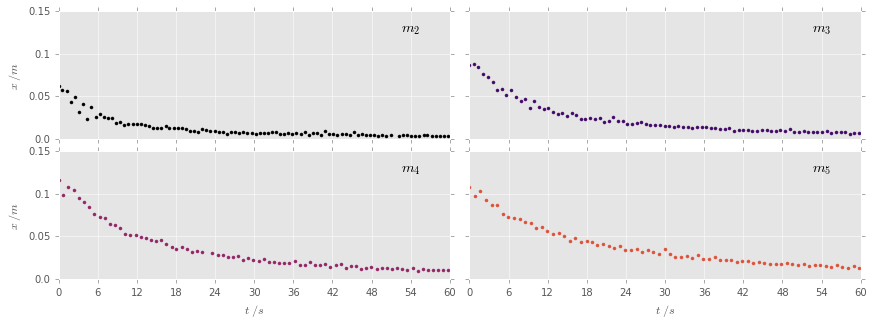

In [20]:
plt.figure(figsize=figsize(3, 2.0/6.0))
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
colors = def_clr(np.linspace(0, 1, 6))
for m, c in zip(masses.keys(), colors):
    plt.subplot(2, 2, m - 1)
    # plt.yscale('log', basey=np.e)
    # plt.ylim([e**-7, e**-3])
    plt.xlim([0, 60])
    plt.xticks(np.linspace(0, 60, 11), [])
    plt.yticks(np.linspace(0, 0.15, 4), [])
    plt.ylim([0, 0.15])
    plt.plot(peaks_time[m], peaks_pos[m]*average_shifted_data[m].ix[0]['P'], '.',
             linewidth=1.5, label = '$m_'+str(m)+'$', color=c)
#     plt.plot(average_shifted_data_full[m]['T'], average_shifted_data_full[m]['P'],
#              linewidth=0.5, label = '$m_'+str(m)+'$', color=c, alpha = 0.4)
    plt.title('$m_'+str(m)+'$', loc='center', y=0.8, x=0.9)
    if m in [2, 4]:
        plt.yticks(np.linspace(0, 0.15, 4), [round(k, 2) for k in np.linspace(0, 0.15, 4)])
        plt.ylabel('$x\;/m$')
    if m in [4, 5]:
        plt.xticks(np.linspace(0, 60, 11), range(0, 61, 6))
        plt.xlabel('$t\;/s$')
savefig('peaks')

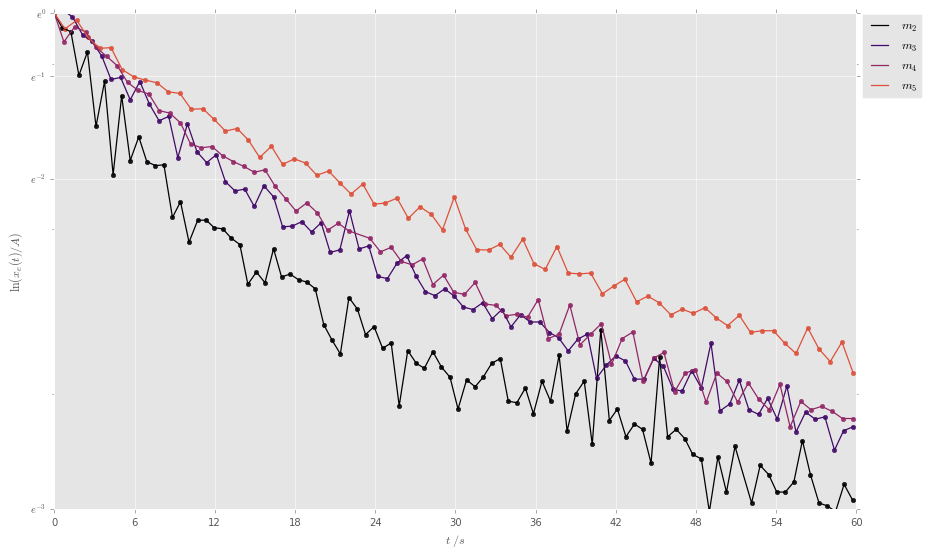

In [21]:
plt.figure(figsize=figsize(3))
colors = def_clr(np.linspace(0, 1, 6))
plt.yscale('log', basey=np.e)
plt.ylim(np.e**-3, np.e**0)
plt.yticks(np.linspace(np.e**(-3), np.e**0+0.001, 4), ['$e^{'+str(k)+'}$' for k in range(-3, 1, 1)])
plt.xticks(np.linspace(0, 60, 11), range(0, 61, 6))
plt.xlim(0, 60)
#plt.yticks([np.linspace(-3, 0, 4)])#, ['e^'+str(k) for k in range(-3, 0)])
for m, c in zip([2, 3, 4, 5], colors[:4]):
#     plt.subplot(4, 1, m-1)
#     scaled_data = average_shifted_data[m]['P']/average_shifted_data[m].ix[0]['P']
#     plt.plot(average_shifted_data[m]['T'], scaled_data)
    plt.scatter(peaks_time[m], peaks_pos[m], color=c, edgecolors=None, alpha=0.9)
    plt.plot(peaks_time[m], peaks_pos[m], linewidth=1.25, color=c, label='$m_'+str(m)+'$')
#     plt.plot(average_shifted_data_full[m]['T'],
#              (average_shifted_data_full[m]['P'].values/average_shifted_data_full[m].ix[0]['P']),
#              'o', linewidth=0.1, color=c, alpha=0.2)
plt.xlabel('$t\;/s$')
plt.ylabel('$\ln({x_e(t)/A)}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
savefig('log_plot_basic')

m:2	y = -0.0413482775813x + -0.730141543825
m:3	y = -0.0397398746177x + -0.382559554377
m:4	y = -0.0396091177005x + -0.320300702928
m:5	y = -0.0334499336674x + -0.222460021849


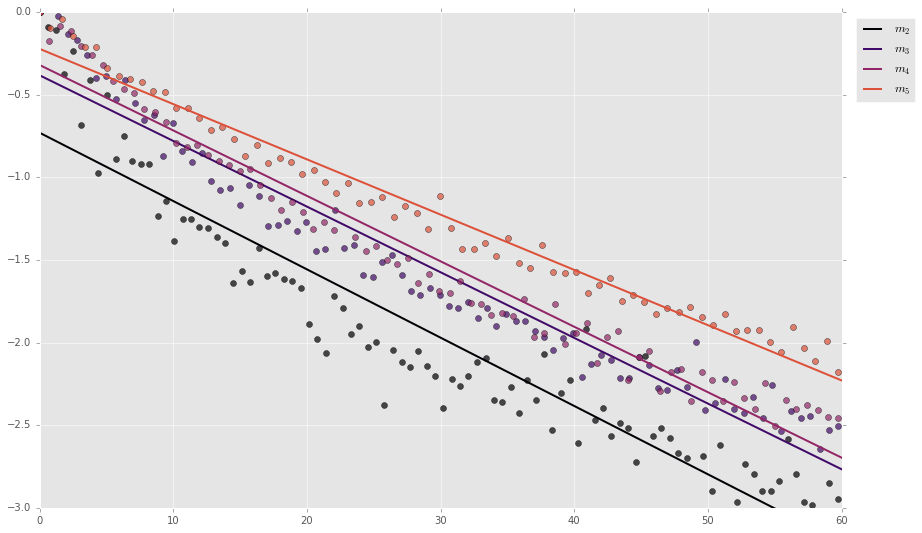

In [22]:
# peaks_pos[2]
# type(shifted_data[2, 1].ix[peaks[m]]['P'].values)
# for i in range(

mass = 4
lines = {}

plt.figure(figsize=figsize(3))
plt.xlim([0, 60])
plt.ylim([-3, 0])
# for tn in range(0, 5):
colors = def_clr(np.linspace(0, 1, 6))
for mass, c in zip([2, 3, 4, 5], colors[:4]):
    plt.plot(peaks_time[mass], peaks_pos_log[mass], 'o',
             linewidth=0.5, color=c, alpha=0.7)
#     plt.plot(average_shifted_data_full[mass]['T'],
#              np.log(average_shifted_data_full[mass]['P'].values/average_shifted_data_full[mass].ix[0]['P']),
#              'o', linewidth=0.1, color=c, alpha=0.1
#              )
#     mx, bx = np.polyfit(peaks_time[mass], peaks_pos_log[mass], 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(peaks_time[mass], peaks_pos_log[mass])
    lines[mass] = (slope, intercept, r_value, p_value, std_err)
    xs = np.linspace(0, 60, 120)
    plt.plot(xs, xs*lines[mass][0] + lines[mass][1], color=c,  linewidth=2, label='$m_'+str(mass)+'$')
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    print "m:{}\ty = {}x + {}".format(mass, slope, intercept)

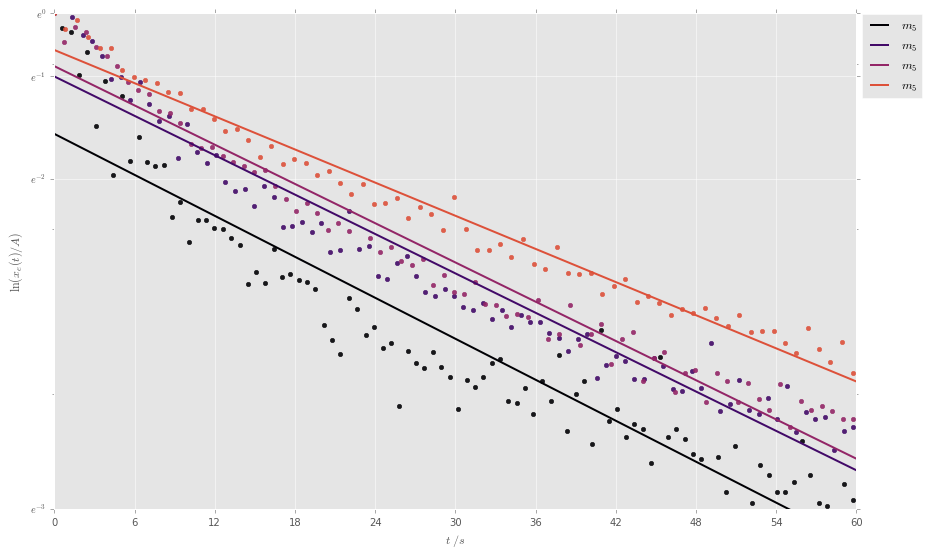

In [23]:
plt.figure(figsize=figsize(3))
colors = def_clr(np.linspace(0, 1, 6))
plt.yscale('log', basey=np.e)
plt.ylim(np.e**-3, np.e**0)
plt.yticks(np.linspace(np.e**(-3), np.e**0+0.001, 4), ['$e^{'+str(k)+'}$' for k in range(-3, 1, 1)])
# plt.yticks(np.linspace(e**(-3), e**0+0.001, 8), ['$e^{'+str(k/2)+'}$' if k%2 == 0 for k in range(-6, 1, 1) else ' '])
plt.xticks(np.linspace(0, 60, 11), range(0, 61, 6))
plt.xlim(0, 60)
#plt.yticks([np.linspace(-3, 0, 4)])#, ['e^'+str(k) for k in range(-3, 0)])
for m, c in zip([2, 3, 4, 5], colors[:4]):
#     plt.plot(peaks_time[m], peaks_pos[m], 'o',
#              linewidth=0.5, color=c, alpha=0.7)
    plt.scatter(peaks_time[m], peaks_pos[m], color=c, edgecolors=None, alpha=0.9)
    ts = np.linspace(0, 60, 100)
    ps = np.e**(lines[m][0]*ts + lines[m][1])
    plt.plot(ts, ps, color=c,  linewidth=2, label='$m_'+str(mass)+'$')
#     plt.plot(average_shifted_data_full[m]['T'],
#              (average_shifted_data_full[m]['P'].values/average_shifted_data_full[m].ix[0]['P']),
#              'o', linewidth=0.1, color=c, alpha=0.2)
plt.xlabel('$t\;/s$')
plt.ylabel('$\ln({x_e(t)/A)}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
savefig('log_plot_bestfit')

In [27]:
for m in [2, 3, 4, 5]:
    print "mass:{}, slope:{},\t b:{}".format(masses[m], lines[m][0], lines[m][0]*masses[m]*-2)
    
slope_header = [' ', '$m\;/kg$', 's', 'b\;/\\nicefrac{kg}{s}']
slope_data = [['$m_{'+str(m)+'}$', masses[m], lines[m][0], lines[m][0]*masses[m]*-2] for m in masses.keys()]
get_latex_table(slope_data, slope_header)

mass:0.29943, slope:-0.0413482775813,	 b:0.0247618295123
mass:0.39908, slope:-0.0397398746177,	 b:0.0317187783249
mass:0.49909, slope:-0.0396091177005,	 b:0.0395370291063
mass:0.59926, slope:-0.0334499336674,	 b:0.040090414499
\begin{tabular}{llll}\\
 	&  $m\;/kg$	&  s	&  b\;/\nicefrac{kg}{s}\\

$m_{2}$	&0.29943	&-0.0413482775813	&0.0247618295123\
$m_{3}$	&0.39908	&-0.0397398746177	&0.0317187783249\
$m_{4}$	&0.49909	&-0.0396091177005	&0.0395370291063\
$m_{5}$	&0.59926	&-0.0334499336674	&0.040090414499\
\end{tabular}


In [29]:
damp_values = [lines[m][0]*masses[m]*-2 for m in masses.keys()]
err_dv = (max(damp_values)*0.5 - min(damp_values)*0.5)
print 'Average:\t{}'.format(np.mean(damp_values))
print 'Error:\t\t{}'.format(err_dv)
print 'Per. Err:\t{}%'.format((err_dv/np.mean(damp_values))*100)

Average:	0.0340270128606
Error:		0.00766429249334
Per. Err:	22.5241414071%


In [26]:
print 'm\tr_value\t\tr_value^2\t\tp_value\t\tstd_err'
for m in masses.keys():
    print '{}\t{}\t{}\t{}\t{}'\
             .format(m, lines[m][2], lines[m][2]**2, lines[m][3], lines[m][4])
        
print 'm\tslope\t\tintercept'
for m in masses.keys():
    print '{}\t{}\t{}'\
             .format(m, lines[m][0], lines[m][1])

m	r_value		r_value^2		p_value		std_err
2	-0.941785674511	0.886960256714	8.26508645628e-46	0.00153066252667
3	-0.971781084971	0.944358477108	7.71405595121e-54	0.0010588111566
4	-0.980529588053	0.961438273047	4.59152559844e-54	0.000922139961731
5	-0.987543017311	0.975241211039	3.71445493093e-57	0.000641622214665
m	slope		intercept
2	-0.0413482775813	-0.730141543825
3	-0.0397398746177	-0.382559554377
4	-0.0396091177005	-0.320300702928
5	-0.0334499336674	-0.222460021849
